## 타이타닉 생존자 예측

In [1]:
# 1. 데이터 로드
import pandas as pd
import numpy as np

train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

train.head()
train.shape, test.shape # test: label 데이터가 빠져있는 상황.

((891, 12), (418, 11))

In [2]:
# EDA (Exploratory Data Analysis): 데이터 훑어보기
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- std가 큰 편차를 갖는 컬럼: Fare, Age (전처리 필요)

In [3]:
train.isna().sum() # Age, Cabin, Embarked
test.isna().sum() # Age, Fare, Cabin

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: xlabel='Pclass'>

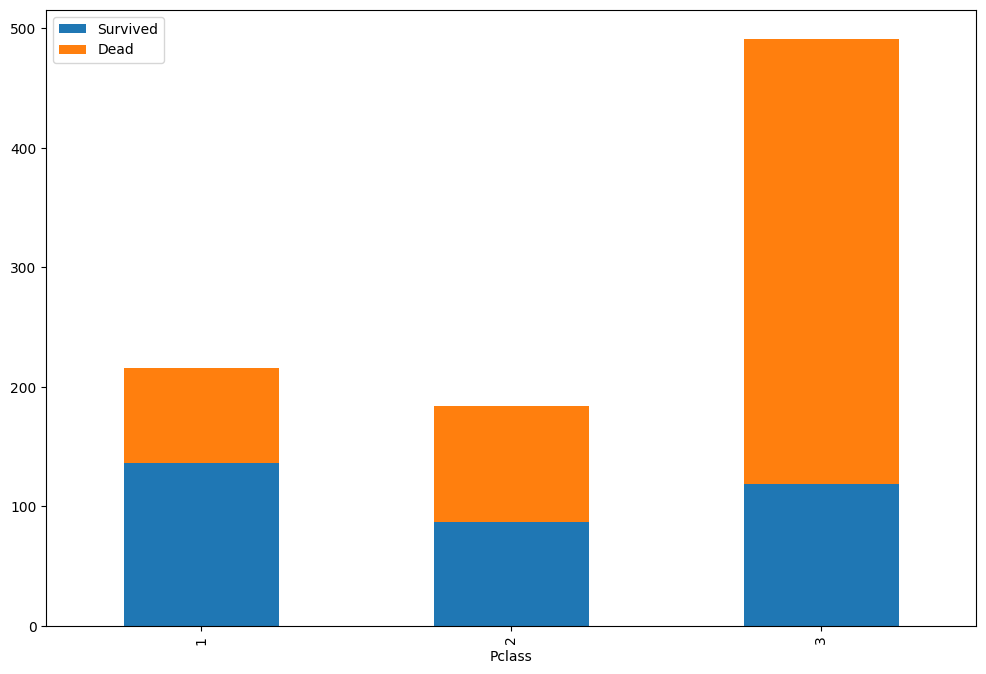

In [4]:
# 시각화
# - 우리가 지금 궁금한 것이 무엇인가요?
# - 생존 확률에 영향을 주는 요소가 무엇인가?
# - 코드 뭉치

survived = train[train['Survived'] == 1]['Pclass'].value_counts()
dead = train[train['Survived'] == 0]['Pclass'].value_counts()

merged_df = pd.DataFrame({
    'Survived' : survived,
    'Dead' : dead
})

merged_df.plot(kind='bar', stacked=True, figsize=(12, 8)) # pandas가 matplotlib을 품고 있다.

In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
def make_bar_chart(column_name):
    survived = train[train['Survived'] == 1][column_name].value_counts()
    dead = train[train['Survived'] == 0][column_name].value_counts()

    merged_df = pd.DataFrame({
        'Survived' : survived,
        'Dead' : dead
    })

    merged_df.plot(kind='bar', stacked=True, figsize=(12, 8)) # pandas가 matplotlib을 품고 있다.

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


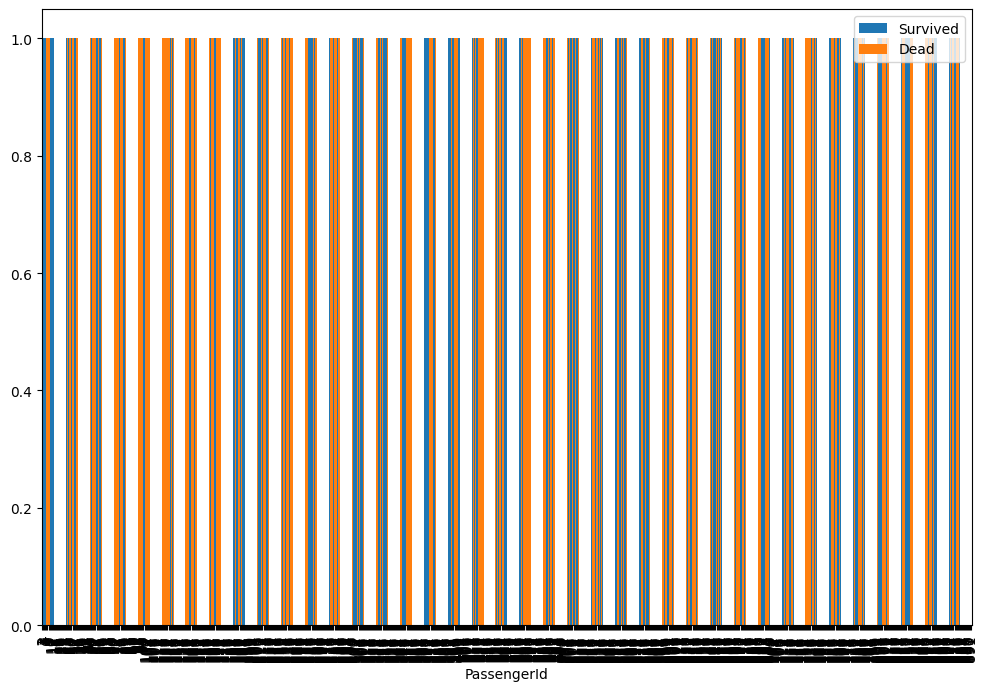

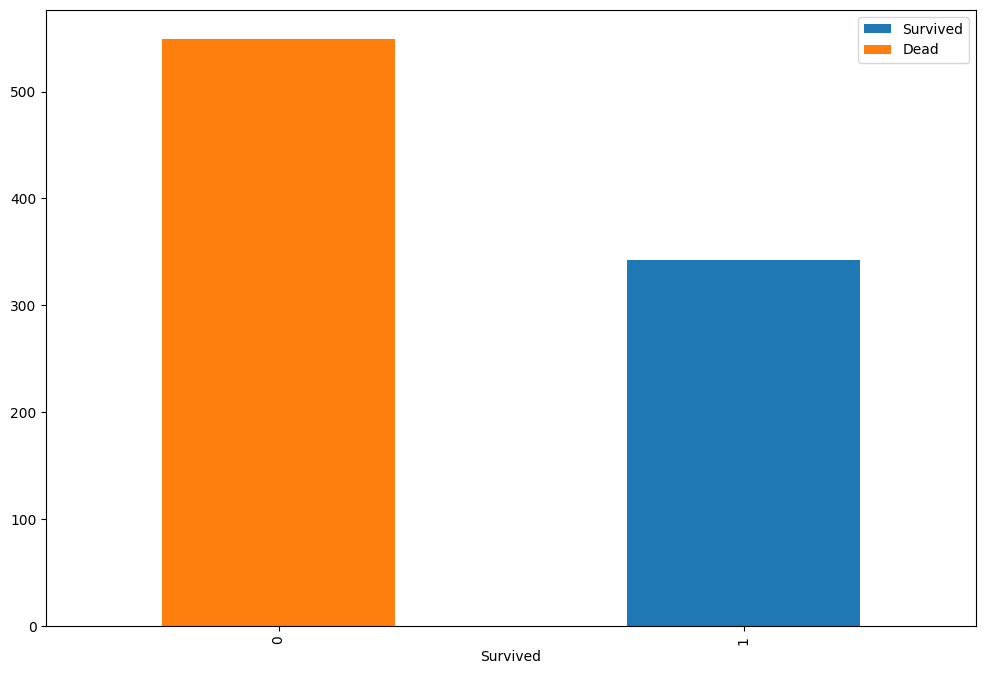

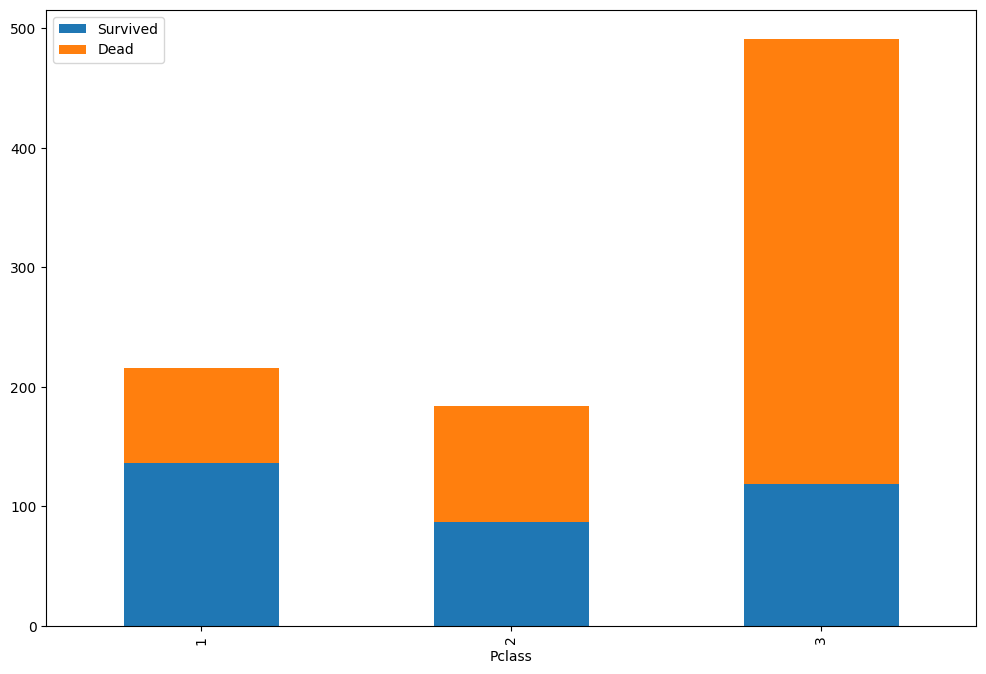

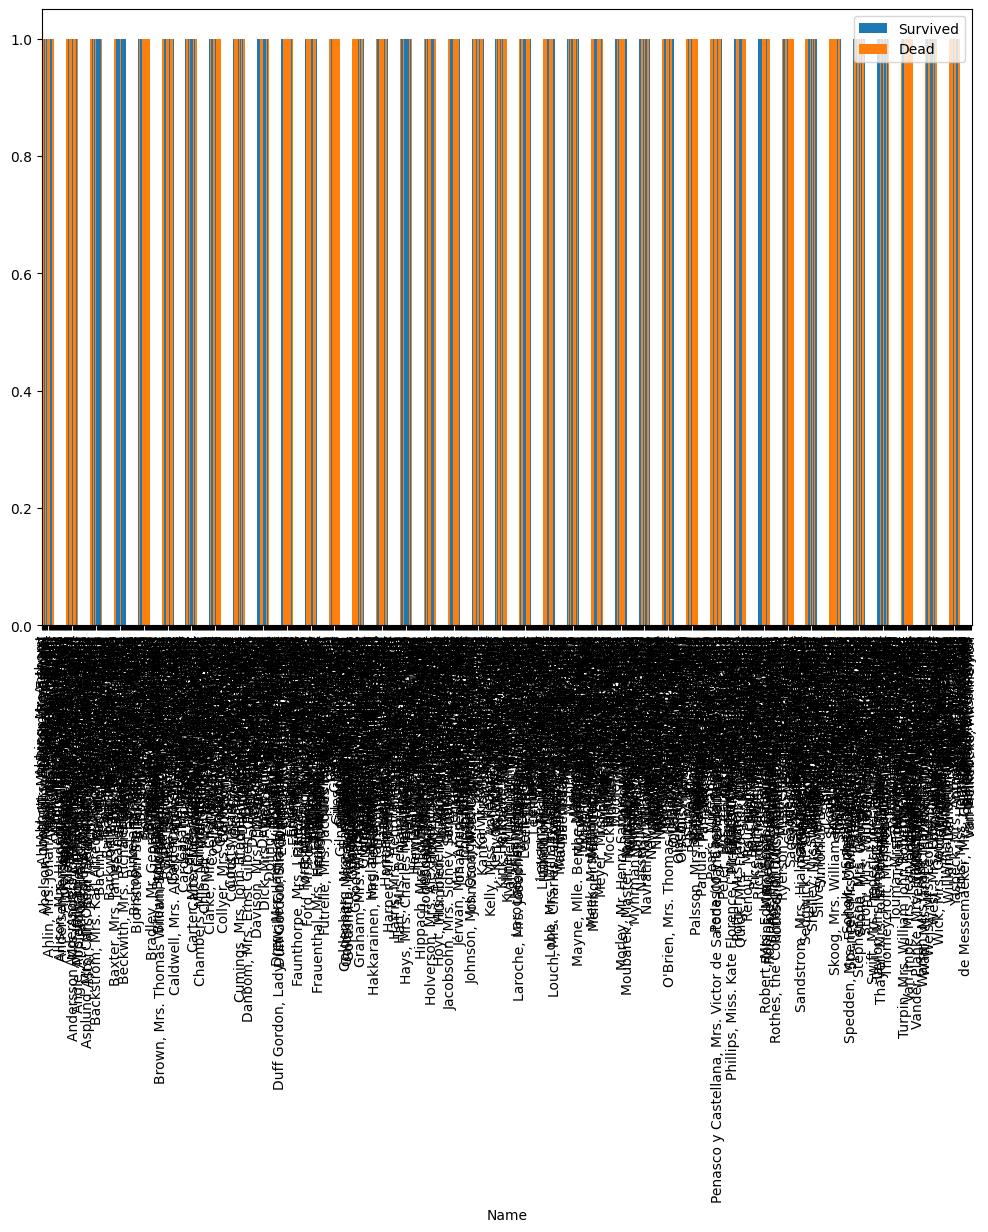

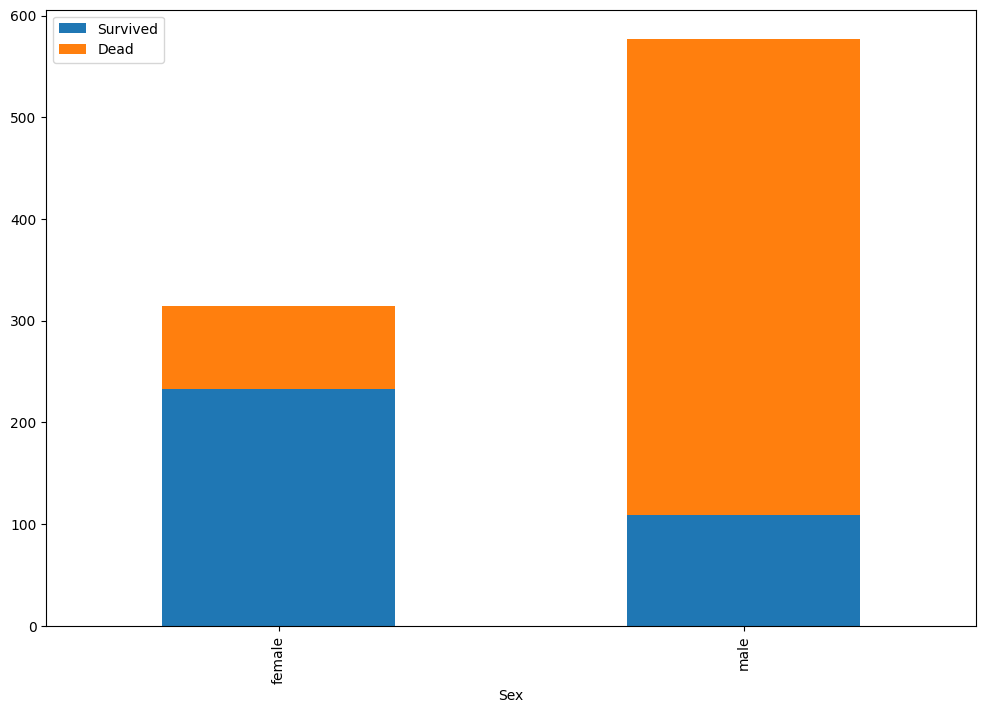

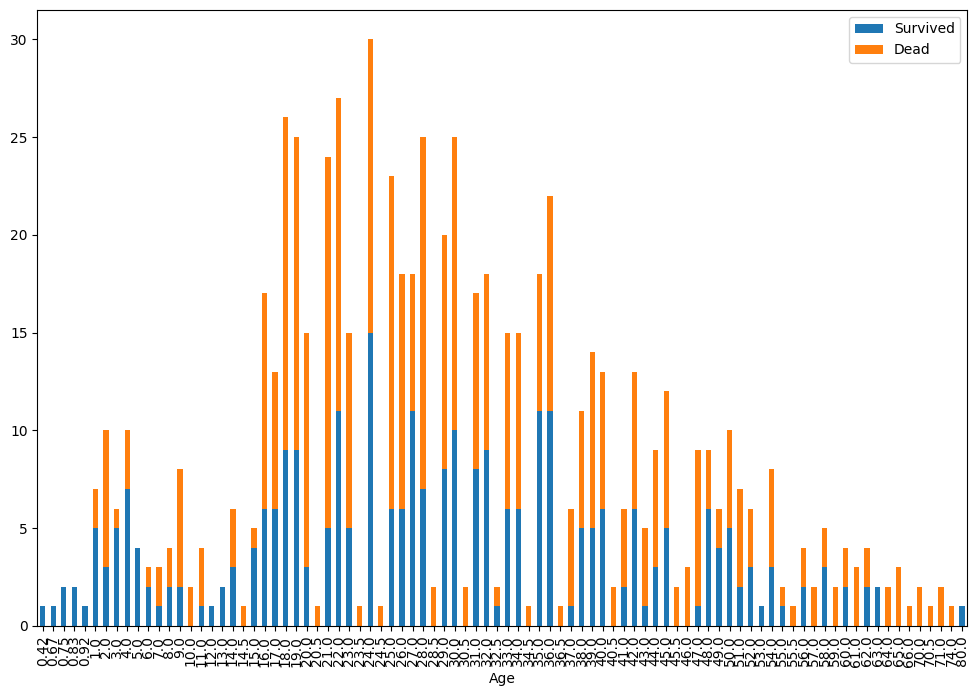

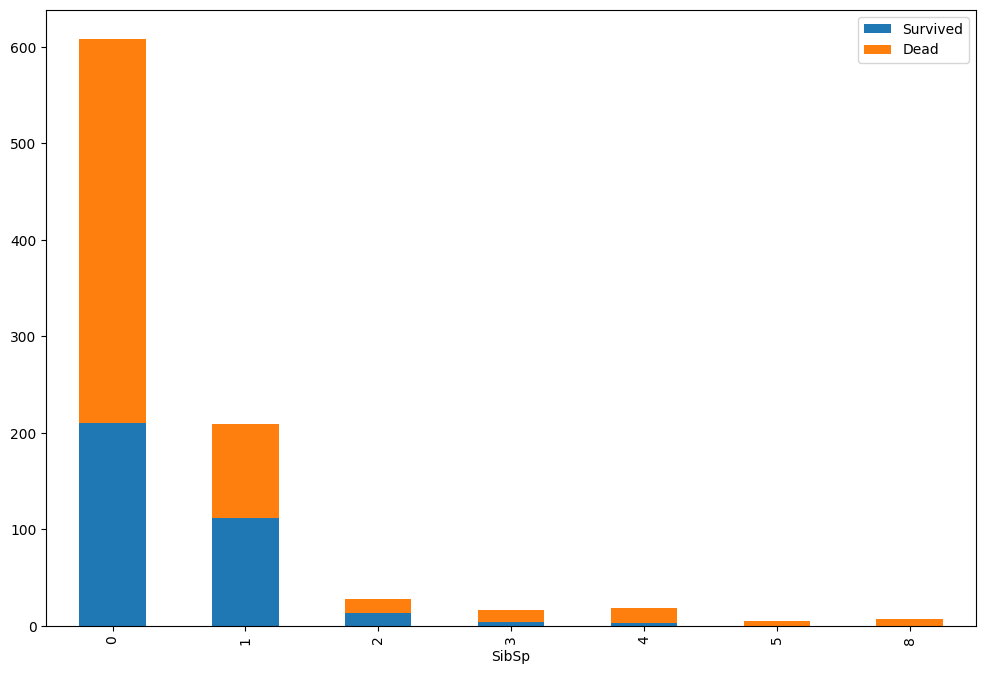

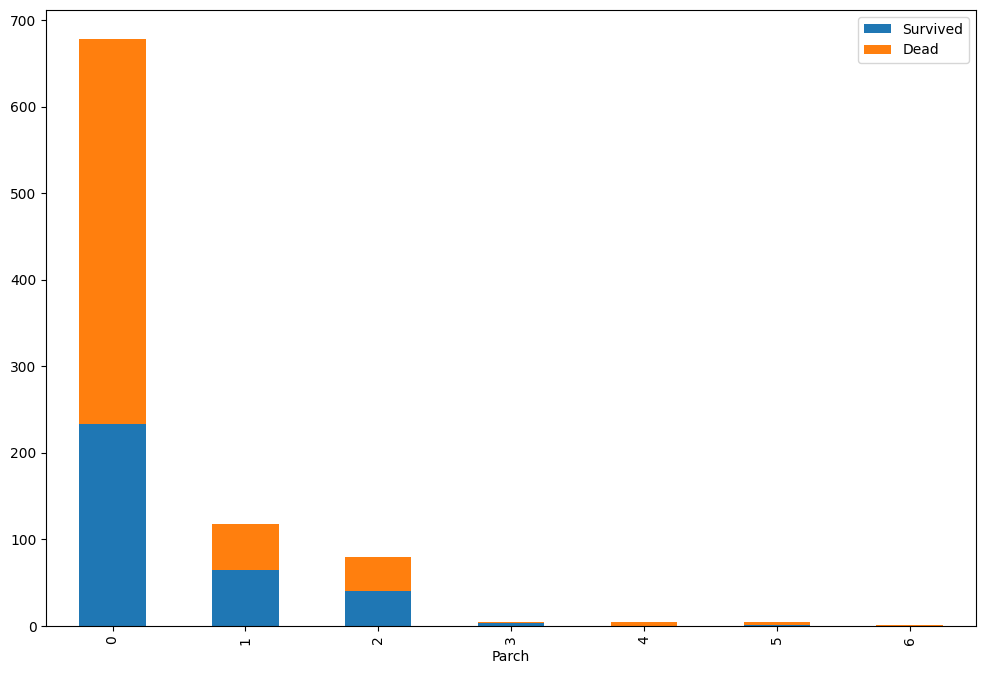

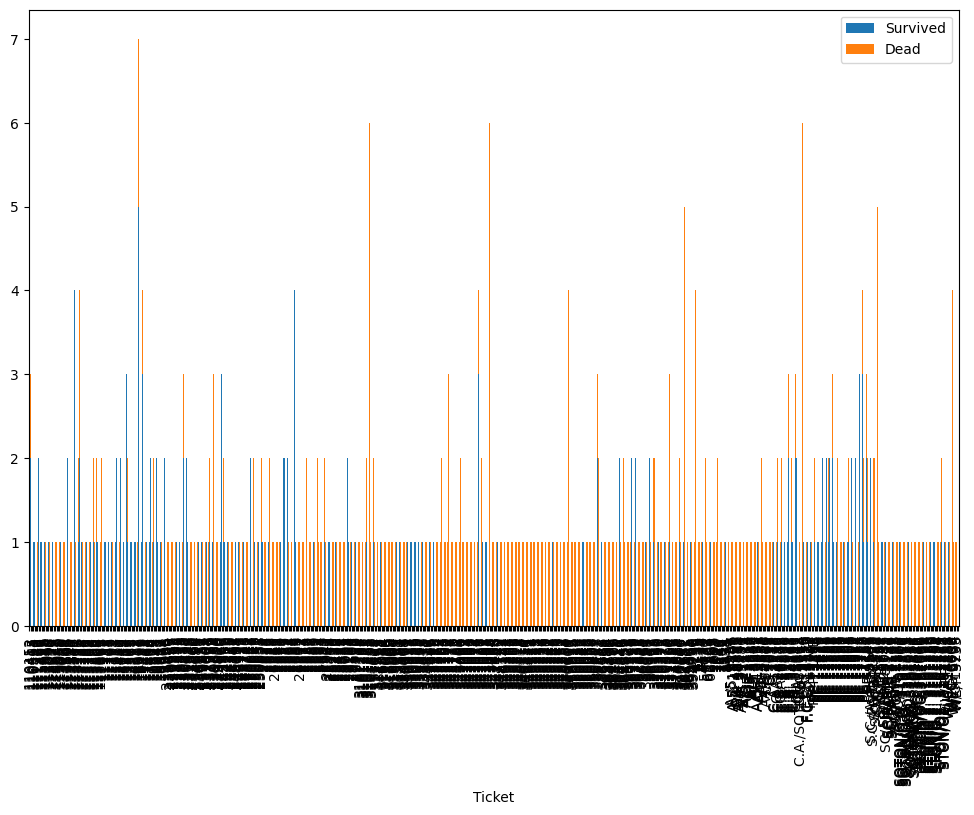

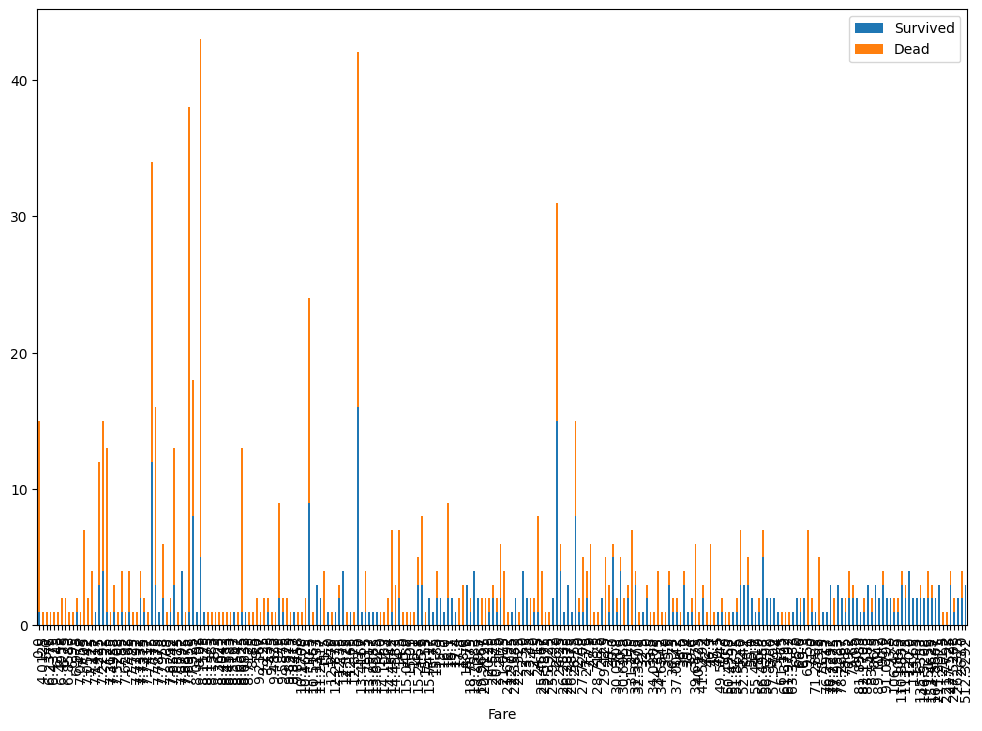

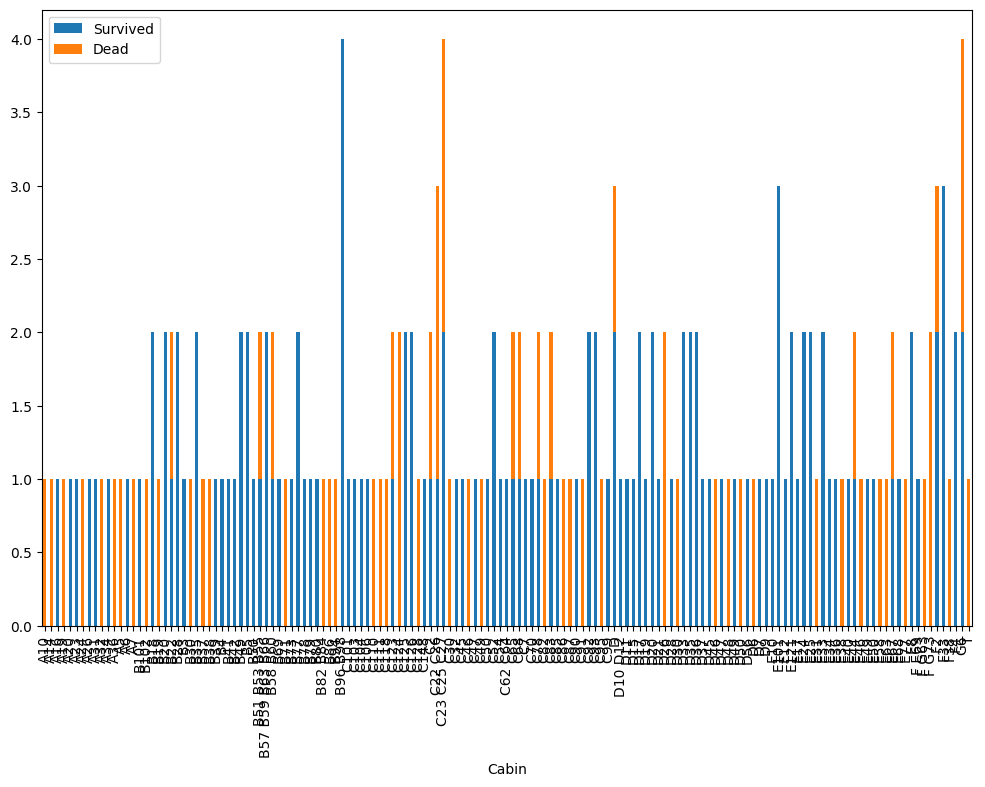

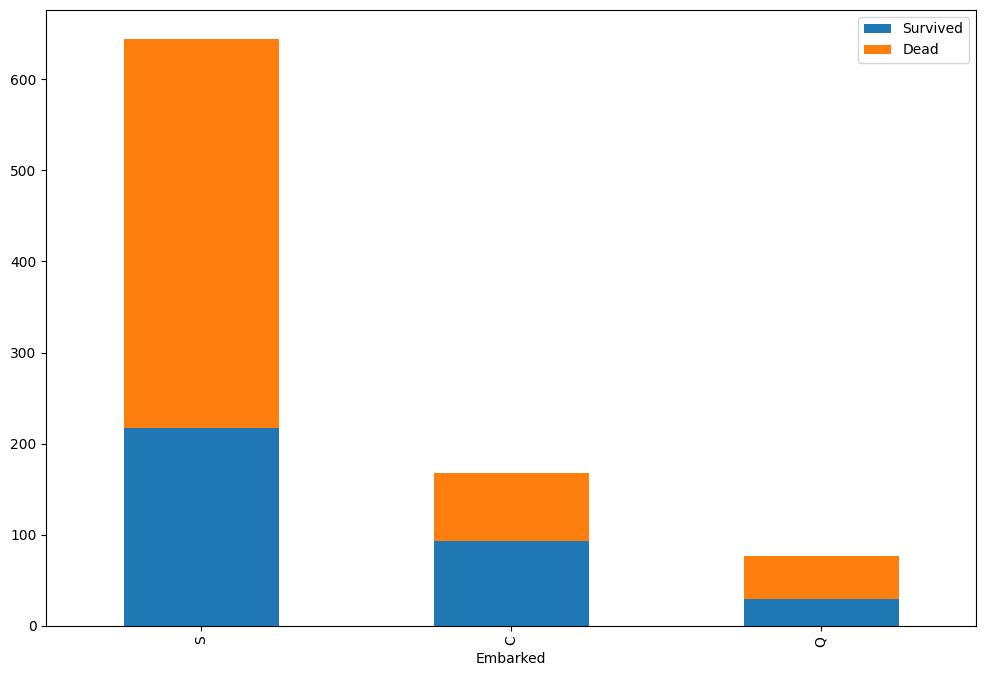

In [7]:
for col in train.columns:
    print(col)
    make_bar_chart(col)

In [8]:
# 생존 확률에 영향을 미치는가? => 생존 확률에 영향을 미치는 컬럼들에 대해서 구분을 할 수 있게 됨.
# - 관계가 있다 => 모델링 할 때 요금을 모델링 컬럼으로 포함 시키는 거죠.
# Q. 타이타닉에서 가장 높은 요금을 낸 상위 10명의 생존 확률과 가장 낮은 요금을 낸 하위 10명의 생존확률을 비교하시오.
train.sort_values(by=['Fare'])[['Name', 'Sex', 'Embarked', 'Fare', 'Survived']].head(10)
train.sort_values(by=['Fare'])[['Name', 'Sex', 'Embarked', 'Fare', 'Survived']].tail(10)

,Name,Sex,Embarked,Fare,Survived
299,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,C,247.5208,1
742,"Ryerson, Miss. Susan Parker ""Suzette""",female,C,262.3750,1
311,"Ryerson, Miss. Emily Borie",female,C,262.3750,1
27,"Fortune, Mr. Charles Alexander",male,S,263.0000,0
88,"Fortune, Miss. Mabel Helen",female,S,263.0000,1
438,"Fortune, Mr. Mark",male,S,263.0000,0
341,"Fortune, Miss. Alice Elizabeth",female,S,263.0000,1
737,"Lesurer, Mr. Gustave J",male,C,512.3292,1
258,"Ward, Miss. Anna",female,C,512.3292,1
679,"Cardeza, Mr. Thomas Drake Martinez",male,C,512.3292,1


In [9]:
# Q.65세 이상 고령자분들의 생존 확률은 어떻게 될까요?
조건1 = train['Age'] >= 65
조건2 = train['Age'] <= 10

train[조건1][['Name', 'Sex', 'Embarked', 'Fare', 'Age', 'Survived']]
train[조건2][['Name', 'Sex', 'Embarked', 'Fare', 'Age', 'Survived']]

train[조건2][['Survived']].mean()

Survived    0.59375
dtype: float64

In [10]:
# 미국 사회에 살고 있어요. 흑인으로 태어났어. 근데 내 아이가 성공했으면 좋겠어. => 제일 먼저 뭘해야 할까요?
# - 수욱: 성공한 흑인 사례 => 성공한 흑인이 태어난 동네로 이사를 가는 겁니다.


## Feature Engineering
- 기계가 학습하기 좋은 형태로 데이터를 구성

- 1. Name
- 2. Sex
- 3. Age
- 4. 

In [11]:
# (1) Name
# 이름은 생존 확률에 영향을 주나요!? 안주나요!?

train['Name_Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
train['Name_Title'].value_counts()
# make_bar_chart('Name_Title')

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/823090376.py:4: SyntaxWarning: invalid escape sequence '\.'
  train['Name_Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')


Name_Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [12]:
title_mapping = {
    "Mr":0, "Miss":1, "Mrs":2, "Master":3, "Dr": 3
}

train['Name_Title_Num'] = train['Name_Title'].map(title_mapping).fillna(3)

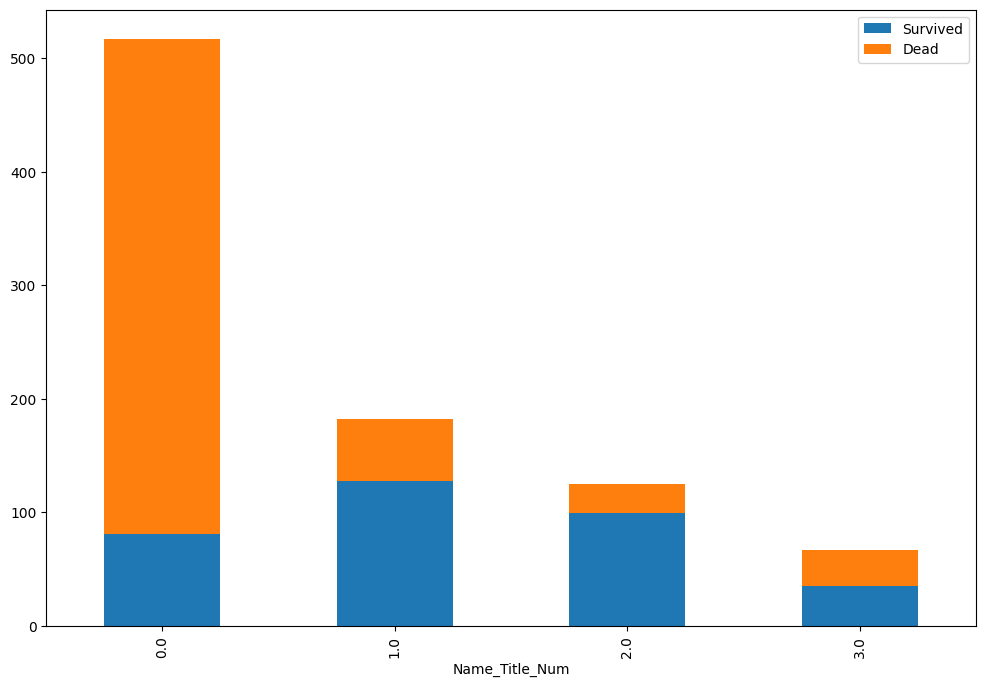

In [13]:
make_bar_chart('Name_Title_Num')

In [14]:
test['Name_Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/2337519869.py:1: SyntaxWarning: invalid escape sequence '\.'
  test['Name_Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')


In [15]:
test['Name_Title_Num'] = test['Name_Title'].map(title_mapping).fillna(3)
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Title,Name_Title_Num
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,2.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr,0.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona,3.0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,0.0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,0.0


In [16]:
# (2) Sex: 성별
train_test_data = [train, test]

for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].replace({'male':0, 'female':1})

# train['Sex'].replace({
#     'male': 0,
#     'female': 1
# })

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/3050255730.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sex'] = dataset['Sex'].replace({'male':0, 'female':1})


In [17]:
# (3) Age: 나이
# Q.비어있는 데이터를 어떻게 처리하지? - 어떻게 잘 채울 수 있을까요?

train['Age'].isna().sum() # 900 / 200 (1/4) 25%

# 그럼 아까 이름으로 나이를 예측해 보는건 어떨까요?
# train.groupby('Name_Title')['Age'].mean()
train.groupby('Name_Title')['Age'].transform('mean')

train['Age'].fillna(train.groupby('Name_Title')['Age'].transform('mean'), inplace=True)
# 휴지통 비울 때 -> 정말로 지우시겠습니까? -> UI/UX -> 소송을 막기 위함. / 우리는 절대 데이터 삭제안합니다. 당신이 동의하지 않으면. 

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/4104725076.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train.groupby('Name_Title')['Age'].transform('mean'), inplace=True)


In [18]:
train['Age']

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    21.773973
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

In [19]:
test['Age'].fillna(test.groupby('Name_Title')['Age'].transform('mean'), inplace=True)

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/2082205823.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Age'].fillna(test.groupby('Name_Title')['Age'].transform('mean'), inplace=True)


In [20]:
test['Age'].fillna(test['Age'].mean(), inplace=True)
test['Age'].isna().sum()

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/3562754871.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Age'].fillna(test['Age'].mean(), inplace=True)


0

In [21]:
# 채용설명회
# - 끝나고 해설도 한번 해드릴게요! :)
# - 4시쯤 뵙겠습니다!

# 기술스택 상관없이 그냥 지원하시면 된다.
# 백엔드 프레임워크 하나정도는 배워두자.
# 어쩄든 들어가서 졸라게 하면됩니다.
# 학벌이 좋지가 않아서 몸빵.
# 신입일 때 회사 근처 집구하고, 주말에도 일하면서 채워가시면 됩니다! :)
# 그러면서 하나 차곡차곡 쌓아가시면 됩니다.
# 하나 기업 => 그렇게 어렵지 않아요.
# 소개팅 100명 => 이 중에 한명은 나랑 결혼하자고 하지않을까요? 

In [22]:
train['Age'].value_counts().to_frame()
# 나이값의 범위가 굉장히 넓다.

# 밀도함수
import seaborn as sns
# sns.kdeplot(train['Age'])

age_bins=[0, 15, 25, 40, np.inf]
age_labels=[0, 1, 2, 3]

train['Age'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels)
test['Age'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels)

In [23]:
# (4) Embarked
train['Embarked'].value_counts()
train['Embarked'].fillna('S', inplace=True)

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/290453103.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna('S', inplace=True)


In [24]:
train['Embarked'].isna().sum()

0

In [25]:
# 기계는 문자열을 인식한다 못한다? => 못한다.
train['Embarked'].value_counts()

embarked_mapping = {
    'S':0, 'C':1, 'Q':2
}

train['Embarked'] = train['Embarked'].replace(embarked_mapping)
test['Embarked'] = test['Embarked'].replace(embarked_mapping)

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/3712449919.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Embarked'] = train['Embarked'].replace(embarked_mapping)
/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/3712449919.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Embarked'] = test['Embarked'].replace(embarked_mapping)


In [26]:
train['Embarked'].value_counts()

Embarked
0    646
1    168
2     77
Name: count, dtype: int64

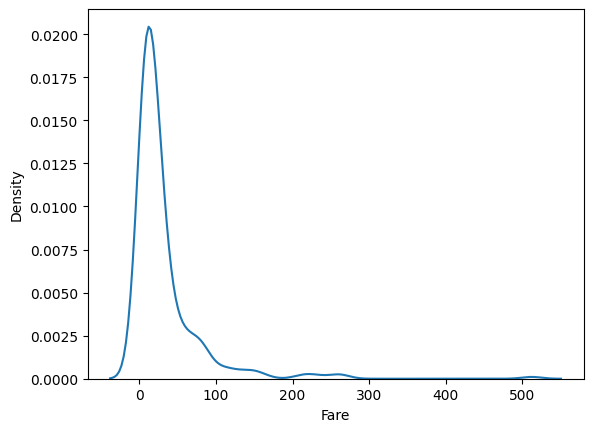

In [27]:
# (5) Fare
train['Fare'].value_counts()

sns.kdeplot(train['Fare'])

fare_bins=[0, 20, 100, np.inf]
fare_labels=[0, 1, 2]

train['Fare'] = pd.cut(train['Fare'], bins=fare_bins, labels=fare_labels)
test['Fare'] = pd.cut(test['Fare'], bins=fare_bins, labels=fare_labels)

In [28]:
train['Fare'] = train['Fare'].astype(str)
train['Fare'].fillna('0', inplace=True)

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/2619865927.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Fare'].fillna('0', inplace=True)


In [29]:
train.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            0
Name_Title          0
Name_Title_Num      0
dtype: int64

In [30]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Name_Title']
df_train = train.drop(drop_features, axis=1)

In [31]:
test['Fare'] = test['Fare'].astype(str)
test['Fare'].fillna('0', inplace=True)

df_test = test.drop(drop_features, axis=1)
df_test.isna().sum()

/var/folders/c0/2pg0gyr14c5gy82gltqzglj40000gn/T/ipykernel_15352/4177047746.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Fare'].fillna('0', inplace=True)


Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Embarked          0
Name_Title_Num    0
dtype: int64

In [32]:
df_train, df_test

(     Survived  Pclass  Sex Age  SibSp  Parch Fare  Embarked  Name_Title_Num
 0           0       3    0   1      1      0    0         0             0.0
 1           1       1    1   2      1      0    1         1             2.0
 2           1       3    1   2      0      0    0         0             1.0
 3           1       1    1   2      1      0    1         0             2.0
 4           0       3    0   2      0      0    0         0             0.0
 ..        ...     ...  ...  ..    ...    ...  ...       ...             ...
 886         0       2    0   2      0      0    0         0             3.0
 887         1       1    1   1      0      0    1         0             1.0
 888         0       3    1   1      1      2    1         0             1.0
 889         1       1    0   2      0      0    1         1             0.0
 890         0       3    0   2      0      0    0         2             0.0
 
 [891 rows x 9 columns],
      Pclass  Sex Age  SibSp  Parch Fare  Embarke

## 모델 학습

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [34]:
from sklearn.model_selection import KFold, cross_val_score

In [35]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=123)

In [36]:
dt_clf = DecisionTreeClassifier()
scores = cross_val_score(
    dt_clf,
    df_train.drop(['Survived'], axis=1),
    df_train['Survived'],
    cv=k_fold,
    scoring='accuracy'
)

np.mean(scores) * 100

77.20973782771536

In [37]:
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(
    knn,
    df_train.drop(['Survived'], axis=1),
    df_train['Survived'],
    cv=k_fold,
    scoring='accuracy'
)

np.mean(scores) * 100

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/neighbors/_base.py", line 682, in _fit
    self._tree = KDTree(
                 ^^^^^^^
  File "sklearn/neighbors/_binary_tree.pxi", line 893, in sklearn.neighbors._kd_tree.BinaryTree64.__init__
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input contains NaN.


In [38]:
rf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(
    rf,
    df_train.drop(['Survived'], axis=1),
    df_train['Survived'],
    cv=k_fold,
    scoring='accuracy'
)

np.mean(scores) * 100

79.34581772784021

In [39]:
svc = SVC()
scores = cross_val_score(
    svc,
    df_train.drop(['Survived'], axis=1),
    df_train['Survived'],
    cv=k_fold,
    scoring='accuracy'
)

np.mean(scores) * 100

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/a-07/Desktop/mlops-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [40]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(df_train.drop(['Survived'], axis=1), df_train['Survived'])

pred = rf.predict(df_test)

In [42]:
df_result = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived':pred
})

df_result.to_csv('submission.csv', index=False)

In [43]:
df_result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## MLflow를 활용한 모델 학습 Tracking -> 모델 개선 -> 한 번 더 제출

In [44]:
# mlflow ui - 실행여부 체크 (로컬이니깐 로컬에서 돌아가는 부분을 체크)
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.create_experiment("titanic_experiment")
mlflow.set_experiment("titanic_experiment")

<Experiment: artifact_location='mlflow-artifacts:/106466394495968796', creation_time=1724199639863, experiment_id='106466394495968796', last_update_time=1724199639863, lifecycle_stage='active', name='titanic_experiment', tags={}>

In [56]:
mlflow.autolog()

models = {
    "DecisionTree": DecisionTreeClassifier(),
    "KNeighbors": KNeighborsClassifier(n_neighbors=10),
    "RandomForest": RandomForestClassifier(n_estimators=10),
    "GaussianNB": GaussianNB(),
    "SVC": SVC()
}

2024/08/21 10:22:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [ ]:
for model_name,model in models.items():
    with mlflow.start_run(run_name=model_name):
        scores = cross_val_score(
            model,
            df_train.drop(['Survived'], axis=1),
            df_train['Survived'],
            cv=k_fold,
            scoring='accuracy'
        )

        mean_score = np.mean(scores) * 100

        mlflow.log_param(f"{model_name}_cv_folds", k_fold.get_n_splits())
        mlflow.log_metric(f"{model_name}_mean_accuracy", mean_score)

        print(f'{model_name}s final score : {mean_score}')

In [49]:
df_train[df_train['Fare'] == 'nan']

# Pclass: 3등급 => Fare: 0
# Pclass: 2등급 => Fare: 1
# Pclass: 1등급 => Fare: 2

pclass_mapping ={
    3: 0,
    2: 1,
    1: 2
}

df_train.loc[df_train['Fare'] == 'nan', ['Fare']] = df_train[df_train['Fare'] == 'nan']['Pclass'].map(pclass_mapping)

In [50]:
df_train['Fare'].unique()

array(['0', '1', '2', 0, 2, 1], dtype=object)

In [51]:
df_train['Fare'] = df_train['Fare'].astype('int')
df_train['Fare'].unique()

array([0, 1, 2])

In [52]:
df_test.loc[df_test['Fare'] == 'nan', ['Fare']] = df_test[df_test['Fare'] == 'nan']['Pclass'].map(pclass_mapping)

In [53]:
df_test['Fare'].unique()

array(['0', '1', '2', 0, 2], dtype=object)

In [54]:
df_test['Fare'] = df_test['Fare'].astype('int')
df_test['Fare'].unique()

array([0, 1, 2])

# SVC 모델 최적화
- 정확도:83.16104868913857
- 목표 : 더 높은 정확도를 내는 모델 파라미터 값을 찾는 것

In [58]:
def model_hyperparameters_tunning(c, gamma, kernel):
    with mlflow.start_run():
        svc = SVC(C=c, gamma=gamma, kernel=kernel)

        scores = cross_val_score(
        svc,
        df_train.drop(['Survived'], axis=1),
        df_train['Survived'],
        scoring='accuracy'
        )
        
        mean_score = np.mean(scores) * 100

        mlflow.log_param(f"{model_name}_cv_folds", k_fold.get_n_splits())
        mlflow.log_metric(f"{model_name}_mean_accuracy", mean_score)

        print(f'{model_name}s final score : {mean_score}')

In [60]:
import warnings
warnings.filterwarnings('ignore', message=".*Inferred schema contains integer columns")

In [ ]:
c_params = [0.1, 1, 10, 100]
gamma_params = [0.01, 0.1, 1]
kernel_params = ['linear', 'rbf', 'poly']

# 4 * 3 * 3 = 36가지의 케이스가 존재

for c in c_params:
    for gamma in gamma_params:
        for kernel in kernel_params:
            model_hyperparameters_tunning(c, gamma, kernel)

In [62]:
# 모델 등록 및 모델 로드 => 캐글 데이터 예측 및 제출
import mlflow
logged_model = 'runs:/7b37d36d7d2044a7bd823f3e1d143940/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: 7b37d36d7d2044a7bd823f3e1d143940

In [63]:
df_test['Age'] = df_test['Age'].astype('int')

In [64]:
# Predict on a Pandas DataFrame.
pred = loaded_model.predict(df_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [65]:
df_result = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': pred
})

df_result.to_csv('submission.csv', index=False)

In [66]:
result = pd.read_csv('submission.csv', index_col=0)
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
